# Deep Learning
## Summative assessment
### Coursework 1: MLPs and Backpropagation

#### Instructions

This coursework is released on **Wednesday 31st January 9.00** and is due by **Wednesday 7th February 23.59**. It is worth **10%** of your overall mark. There are 3 questions in this assessment, worth a total of 90 marks. A further 10 marks are awarded for good code quality, clarity and presentation. **You should attempt to answer all questions.** 

This assessment mainly assesses your understanding of the multilayer perceptron model and the backpropagation algorithm, as well as your ability to use the high-level Keras API.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also export a PDF file of your executed notebook. Upload a zip file containing your notebook (and separate PDF file) to Coursera by the deadline above.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping

### Question 1 (Total 30 marks)

a) Load the Boston housing dataset using the Keras API, with a 75/25 train/validation split. 

Standardise the input features by subtracting the mean and dividing by the standard deviation, where the per-feature statistics are computed from the training dataset. You can use numpy or sklearn for this part if you wish.

Load the data into `tf.data.Dataset` objects, shuffle and batch the datasets with a batch size of 32. Print out the `element_spec` of one of the Datasets. 

**(5 marks)**

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
def load_boston_housing_data(test_split: float, seed: int = 113):
    return tf.keras.datasets.boston_housing.load_data(
        path="boston_housing.npz", test_split=test_split, seed=seed
    )

In [4]:
def standardise_input_features(x_train: np.ndarray, x_val: np.ndarray):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    
    return x_train, x_val

In [5]:
def to_dataset_objects(x: np.ndarray, y: np.ndarray, batch_size: int = 32):
    return (
        tf.data.Dataset.from_tensor_slices((x, y))
        .shuffle(buffer_size=len(x))
        .batch(batch_size)
    )

In [6]:
(X_train, y_train), (X_val, y_val) = load_boston_housing_data(test_split=0.25)
X_train, X_val = standardise_input_features(X_train, X_val)
train_dataset = to_dataset_objects(X_train, y_train)
val_dataset = to_dataset_objects(X_val, y_val)
train_dataset.element_spec

(TensorSpec(shape=(None, 13), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.float64, name=None))

In [7]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

b) Create a TensorFlow `Sequential` model object according to the following spec:

* The model should have 2 hidden layers, with 32 and 16 neurons respectively
* Each hidden layer should use a 'swish' activation

The model should be an multilayer perceptron (MLP) model suitable for regression on the Boston housing dataset.

Train the model for 300 epochs using the training Dataset object, but terminate the training if the validation mean absolute error (MAE) doesn't improve after 30 epochs. Use the stochastic gradient descent (SGD) optimizer with Nesterov momentum, with the momentum hyperparameter set to 0.9, and a learning rate of $10^{-3}$. You should use the high-level Keras API (using `compile`, `fit` methods) for this. The model should be trained with a mean squared error (MSE) loss function. The mean absolute error should also be computed and recorded on the training and validation sets.

Plot the MSE and MAE learning curves for training and validation sets, and compute the MSE loss and MAE on the validation set for the best set of model parameters (according to the validation set MAE).

**(15 marks)**

In [8]:
def define_mlp_model():
    return Sequential(
        [
            Dense(32, activation="swish", input_shape=(13,)),
            Dense(16, activation="swish"),
            Dense(1),  # output layer for regression
        ]
    )

In [9]:
def compile_model(
    mlp_model: Sequential,
    learning_rate: float,
    momentum: float = 0.9,
    nesterov: bool = True,
    loss: str = "mean_squared_error",
    metrics: str = ["mean_absolute_error"],
):
    mlp_model.compile(
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate, momentum=momentum, nesterov=nesterov
        ),
        loss=loss,
        metrics=metrics,
    )

In [10]:
def fit_model(
    mlp_model: Sequential,
    train_dataset: tf.data.Dataset,
    val_dataset: tf.data.Dataset,
    monitor: str = "val_mean_absolute_error",
    patience: int = 30,
    epochs: int = 300,
):
    early_stopping = EarlyStopping(
        monitor=monitor, patience=patience, restore_best_weights=True
    )

    return mlp_model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping],
    )

In [11]:
def plot_learning_curves(history):
    # Plot MSE and MAE learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train MSE")
    plt.plot(history.history["val_loss"], label="Val MSE")
    plt.title("MSE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["mean_absolute_error"], label="Train MAE")
    plt.plot(history.history["val_mean_absolute_error"], label="Val MAE")
    plt.title("MAE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def compute_mse_mae_losses(mlp_model: Sequential):
    val_mse, val_mae = mlp_model.evaluate(val_dataset)
    print(f"Validation MSE: {val_mse}, Validation MAE: {val_mae}")

In [13]:
mlp_model = define_mlp_model()
compile_model(mlp_model, learning_rate=1e-3)
history = fit_model(mlp_model, train_dataset, val_dataset)

Epoch 1/300
12/12 [==============================] - 0s 7ms/step - loss: 404.7688 - mean_absolute_error: 17.6865 - val_loss: 64.0397 - val_mean_absolute_error: 6.2762
Epoch 2/300
12/12 [==============================] - 0s 1ms/step - loss: 37.7916 - mean_absolute_error: 4.6012 - val_loss: 23.9557 - val_mean_absolute_error: 3.6842
Epoch 3/300
12/12 [==============================] - 0s 965us/step - loss: 22.3019 - mean_absolute_error: 3.0526 - val_loss: 27.6225 - val_mean_absolute_error: 3.5311
Epoch 4/300
12/12 [==============================] - 0s 1ms/step - loss: 14.2343 - mean_absolute_error: 2.5918 - val_loss: 24.6338 - val_mean_absolute_error: 3.1591
Epoch 5/300
12/12 [==============================] - 0s 988us/step - loss: 12.1294 - mean_absolute_error: 2.4913 - val_loss: 23.3336 - val_mean_absolute_error: 3.0436
Epoch 6/300
12/12 [==============================] - 0s 776us/step - loss: 11.2284 - mean_absolute_error: 2.3487 - val_loss: 23.8285 - val_mean_absolute_error: 3.0348
Ep

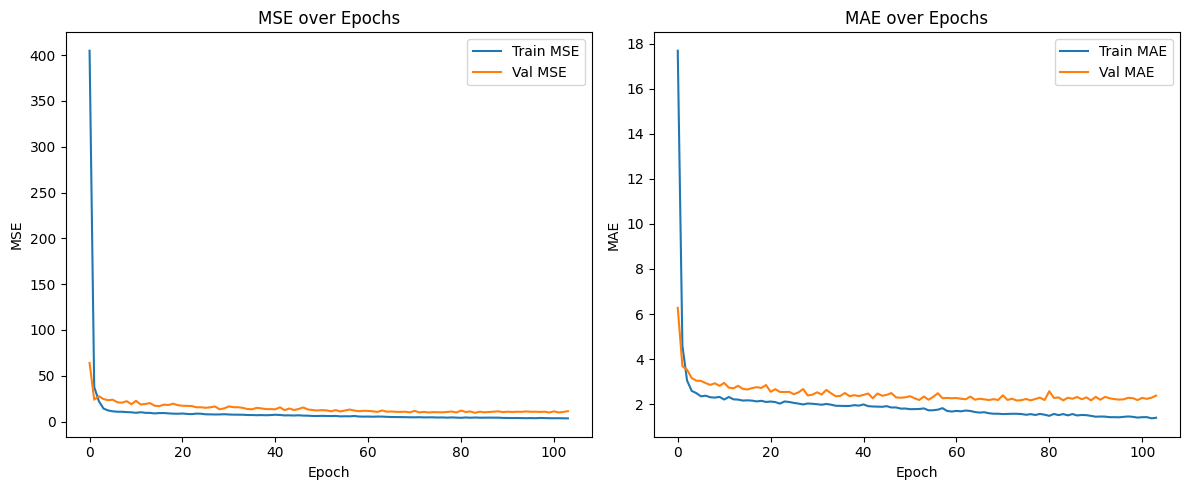

In [14]:
plot_learning_curves(history)

In [15]:
compute_mse_mae_losses(mlp_model)

4/4 [==============================] - 0s 687us/step - loss: 9.9421 - mean_absolute_error: 2.1631
Validation MSE: 9.942085266113281, Validation MAE: 2.163083076477051


c) What do you expect would be the effect of training the same model architecture on the Boston housing dataset where the input features have not been standardised? Briefly justify your answer. 

**(5 marks)**

The Boston Housing dataset contains features with varying scales - there are features with values in the interval [5, 10] as well features with values in the hundred. Apart from the possibility of the model to incorrectly interpret the data, such varying scales might significantly slow down the convergence of the training process, in this case SGD. The non-standardized features might also make the model more sensitive to the choice of the learning rate and the initial weights. Weights might update with different speed, leading to an unstable training process. Moreover, the activation function `swish`` is affected by the scale of the input values which can influence the learning and performance of the model. In general, the model might perform worse, both in terms of training efficiency and in achieving a lower final error rate.

Let's train the model without standradizing the input features:

In [16]:
(X_train_ns, y_train_ns), (X_val_ns, y_val_ns) = load_boston_housing_data(test_split=0.25)
train_dataset_ns = to_dataset_objects(X_train_ns, y_train_ns)
val_dataset_ns = to_dataset_objects(X_val_ns, y_val_ns)

mlp_model_ns = define_mlp_model()
compile_model(mlp_model_ns, learning_rate=1e-3)
fit_model(mlp_model_ns, train_dataset_ns, val_dataset_ns)

Epoch 1/300
12/12 [==============================] - 0s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/300
12/12 [==============================] - 0s 815us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/300
12/12 [==============================] - 0s 757us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/300
12/12 [==============================] - 0s 754us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/300
12/12 [==============================] - 0s 754us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/300
12/12 [==============================] - 0s 791us/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/300
12/12 [==============================] - 0s 736us/step - loss: nan - mea

We obtain only `nan` values for the `loss`, `mean_absolute_error`, and `val_mean_absolute_error`. One hypothesis is that the learning rate might be too high, leading to very large updates that overshoot the optimal values. Let's train the model with a smaller leraning rate of `1e-5`, and show that there are no more `nan` values:

In [17]:
(X_train_ns, y_train_ns), (X_val_ns, y_val_ns) = load_boston_housing_data(test_split=0.25)
train_dataset_ns = to_dataset_objects(X_train_ns, y_train_ns)
val_dataset_ns = to_dataset_objects(X_val_ns, y_val_ns)

mlp_model_ns = define_mlp_model()
compile_model(mlp_model_ns, learning_rate=1e-10)
history_ns = fit_model(mlp_model_ns, train_dataset_ns, val_dataset_ns)

Epoch 1/300
12/12 [==============================] - 0s 5ms/step - loss: 7352.4844 - mean_absolute_error: 83.9114 - val_loss: 7439.9028 - val_mean_absolute_error: 84.0335
Epoch 2/300
12/12 [==============================] - 0s 741us/step - loss: 7258.3892 - mean_absolute_error: 83.3714 - val_loss: 7319.1567 - val_mean_absolute_error: 83.3510
Epoch 3/300
12/12 [==============================] - 0s 709us/step - loss: 7136.4487 - mean_absolute_error: 82.6734 - val_loss: 7188.9033 - val_mean_absolute_error: 82.6079
Epoch 4/300
12/12 [==============================] - 0s 700us/step - loss: 7011.9985 - mean_absolute_error: 81.9444 - val_loss: 7055.3696 - val_mean_absolute_error: 81.8397
Epoch 5/300
12/12 [==============================] - 0s 679us/step - loss: 6885.9609 - mean_absolute_error: 81.2042 - val_loss: 6924.2637 - val_mean_absolute_error: 81.0778
Epoch 6/300
12/12 [==============================] - 0s 691us/step - loss: 6761.9717 - mean_absolute_error: 80.4717 - val_loss: 6796.3477

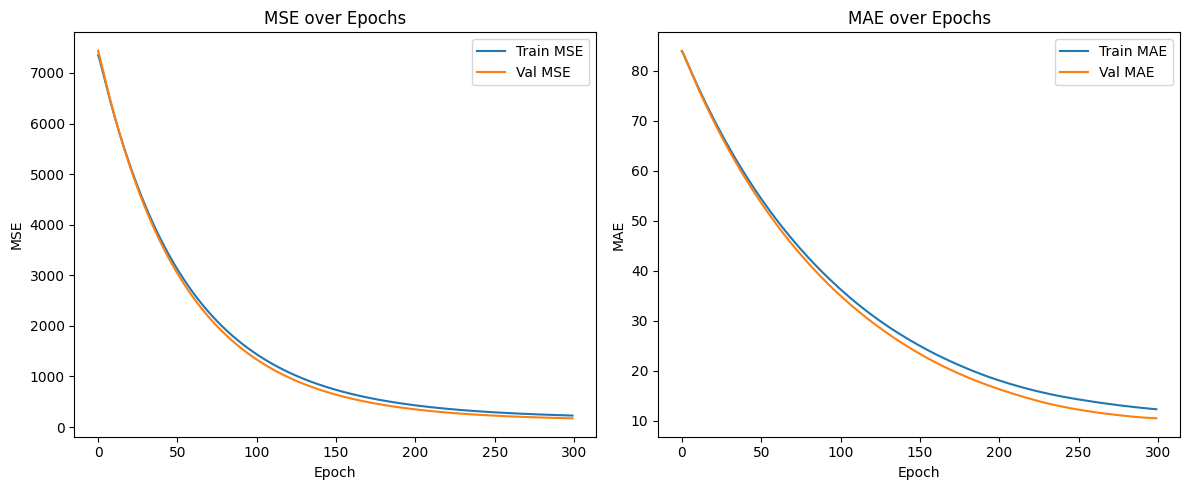

In [18]:
plot_learning_curves(history_ns)

d) In terms of the computations carried out, describe in a few sentences what the differences would be (if any) between standardising the input features as above, and inserting a batch normalisation layer before the first dense layer of the model. 

**(5 marks)**

**Standardizing Input Features Manually:**
   - Scales each feature of the dataset so that they have a mean of 0 and a standard deviation of 1, based on the statistics of the training data.
   - A preprocessing step done before the dataset is fed into the model.
   - Static procedure – it's computed once and doesn't change during the training process.

**Using Batch Normalization Layer:**
   - Normalizes the input or activations of the layer by scaling and shifting them batch-wise during training, and it is based on the statistics of the batch.
   - A dynamic process - as already mentioned the statistics are computed for each batch, and hence change throughout the training. Additionally, it introduces trainable parameters (scale and shift) that are adjusted during training.

### Question 2 (Total 30 marks)

In this question you will empirically study the post-activation statistics in the hidden layers of an MLP model under different initialisation strategies. 

Consider an MLP model with 5 hidden layers with 8192, 8192, 8192, 4096 and 4096 neurons respectively. Each hidden layer uses a tanh activation function. Let $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$ and $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ denote the weight matrix and bias vector that map from hidden layer $k$ to hidden layer $k+1$ according to the following:

$$
\begin{align}
\mathbf{h}^{(k)} &= \tanh\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,\ldots, 5,
\end{align}
$$

where $\mathbf{h}^{(0)} \in \mathbb{R}^{1024}$ denotes the input layer, $n_k$ is the number of neurons in hidden layer $k$, and the tanh function is applied elementwise. Suppose the input features ${h}_i^{(0)}$ are each independently sampled from $N(0, \frac{1}{2})$.

a) Compute the (post-)activations of each hidden layer after passing a single input example through the network (where the input example is sampled as described above), and save them in a variable called `layer_activations`. The following initialisation strategy should be used for the model parameters:

1. Each element in each weight matrix $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$ is sampled from a standard normal distribution
2. Each bias vector $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ is initialised to zero
    
Your answer for this part should use only TensorFlow objects and functions, and not use numpy or scipy at all. You can make use of the Keras module if you wish. Weight and bias parameters should be implemented with TF Variable objects.

**(10 marks)**

In [19]:
class MLP(tf.Module):
    def __init__(self, layer_sizes: list[int]):
        super().__init__()
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(
                {
                    "weights": tf.Variable(
                        tf.random.normal([layer_sizes[i], layer_sizes[i + 1]])
                    ),  # weights from standard normal distribution
                    "biases": tf.Variable(tf.zeros([layer_sizes[i + 1]])),
                }
            )

    def __call__(self, x):
        for layer in self.layers:
            x = tf.matmul(x, layer["weights"]) + layer["biases"]
            x = tf.math.tanh(x)
        return x

In [20]:
layer_sizes = [1024, 8192, 8192, 8192, 4096, 4096]
mlp = MLP(layer_sizes)
input_example = tf.random.normal([1, 1024], mean=0, stddev=tf.sqrt(0.5))

In [21]:
# compute post-activations for each layer
layer_activations = []
x = input_example
for layer in mlp.layers:
    x = tf.matmul(x, layer["weights"]) + layer["biases"]
    x = tf.math.tanh(x)
    layer_activations.append(x)

In [22]:
layer_activations

[<tf.Tensor: shape=(1, 8192), dtype=float32, numpy=
 array([[-0.99999976, -0.99999976, -0.99999976, ...,  0.99999976,
         -0.99999976,  0.99999976]], dtype=float32)>,
 <tf.Tensor: shape=(1, 8192), dtype=float32, numpy=
 array([[ 0.99999976,  0.99999976,  0.99999976, ...,  0.99999976,
          0.99999976, -0.99999976]], dtype=float32)>,
 <tf.Tensor: shape=(1, 8192), dtype=float32, numpy=
 array([[-0.99999976, -0.99999976,  0.99999976, ...,  0.99999976,
         -0.99999976, -0.99999976]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[ 0.99999976,  0.99999976,  0.9999218 , ..., -0.99999976,
          0.99999976, -0.99999976]], dtype=float32)>,
 <tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
 array([[-0.99999976, -0.99999976,  0.99999976, ..., -0.99999976,
          0.99999976,  0.99999976]], dtype=float32)>]

b) Create a plot for the normalised (density) histograms for the activation statistics in each of the hidden layers. Briefly comment on the result.

**(5 marks)**

In [23]:
def plot_histograms(layer_activations):
    num_layers = len(layer_activations)
    fig, axes = plt.subplots(num_layers, 1, figsize=(10, num_layers * 4))

    for i, activations in enumerate(layer_activations):
        activations_np = activations.numpy().flatten()
        axes[i].hist(activations_np, bins=30, density=True)
        axes[i].set_title(f'Layer {i+1} Activation Distribution')
        axes[i].set_xlabel('Activation Value')
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

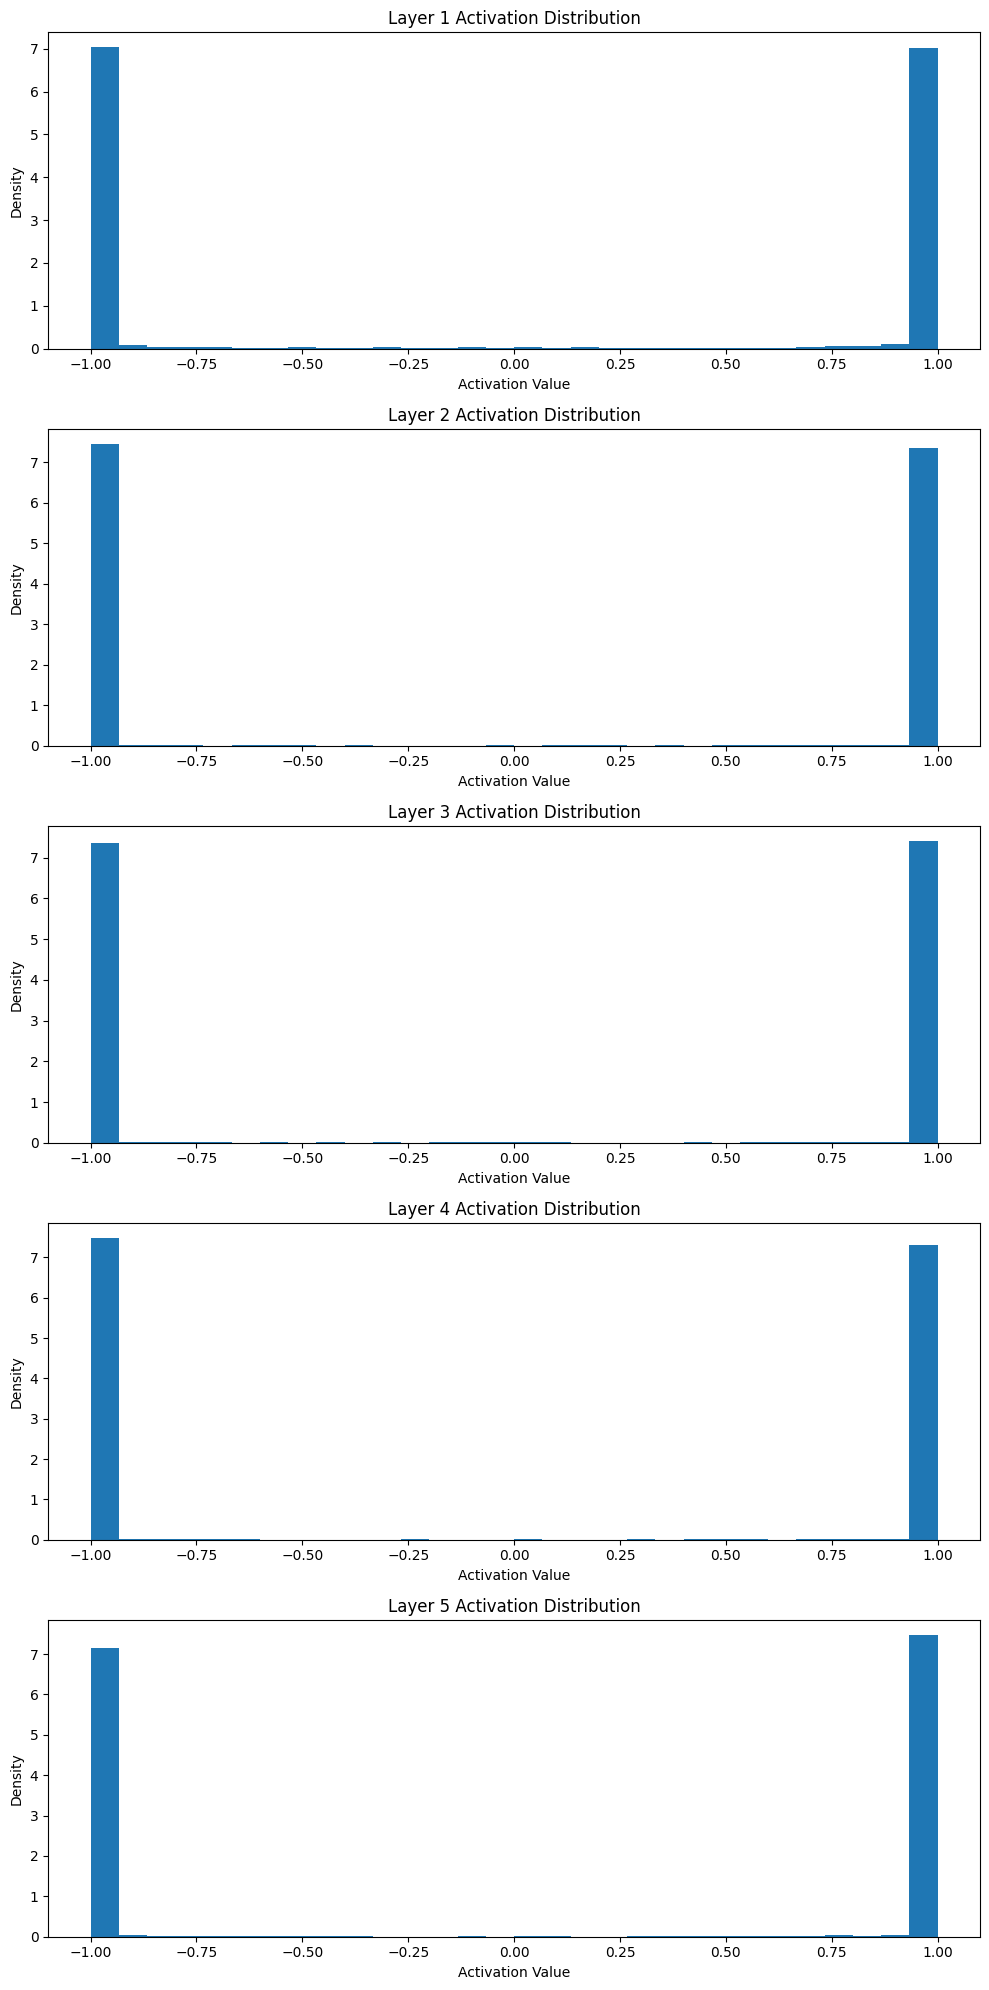

In [24]:
plot_histograms(layer_activations)

The histograms show the distribution of activation values across the five hidden layers of the MLP model after passing through a single input example. All the histograms exhibit a clear bimodal distribution with peaks near the extreme values of the tanh activation function, which are -1 and 1. This indicates that a significant portion of the neurons are saturating, meaning that the inputs to the tanh function are very high or very low. The standard normal initialization of weights might be responsible for the observed saturation. In summary, the current initialization strategy may not be optimal for the network architecture and activation function being used.

c) Re-compute the activation statistics for the MLP under two different initialisation strategies:

1. Glorot normal distribution initialisation for the weights $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$ and zero initialisation for the bias $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ for $k=0,\ldots,4$
1. Glorot uniform distribution initialisation for the weights $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$ and zero initialisation for the bias $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ for $k=0,\ldots,4$

For each initialisation strategy above, plot normalised histograms for the activation statistics in each hidden layer.

**(10 marks)**

In [25]:
class GolorotMLP(tf.Module):
    def __init__(self, layer_sizes, init_strategy):
        super().__init__()
        
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            
            fan_in = layer_sizes[i]
            fan_out = layer_sizes[i + 1]
            
            if init_strategy == "glorot_normal":
                stddev = tf.sqrt(2.0 / (fan_in + fan_out))
                weights = tf.Variable(
                    tf.random.truncated_normal([fan_in, fan_out], stddev=stddev)
                )
            elif init_strategy == "glorot_uniform":
                limit = tf.sqrt(6.0 / (fan_in + fan_out))
                weights = tf.Variable(
                    tf.random.uniform([fan_in, fan_out], minval=-limit, maxval=limit)
                )
                
            biases = tf.Variable(tf.zeros([fan_out]))
            self.layers.append({"weights": weights, "biases": biases})

    def __call__(self, x):
        for layer in self.layers:
            x = tf.matmul(x, layer["weights"]) + layer["biases"]
            x = tf.math.tanh(x)  # tanh activation function
        return x

Golorot normal distribution:

In [26]:
mlp_glorot_normal = GolorotMLP(layer_sizes, init_strategy='glorot_normal')
layer_activations_glorot_normal = []
x = input_example
for layer in mlp_glorot_normal.layers:
    x = tf.matmul(x, layer['weights']) + layer['biases']
    x = tf.math.tanh(x)
    layer_activations_glorot_normal.append(x)

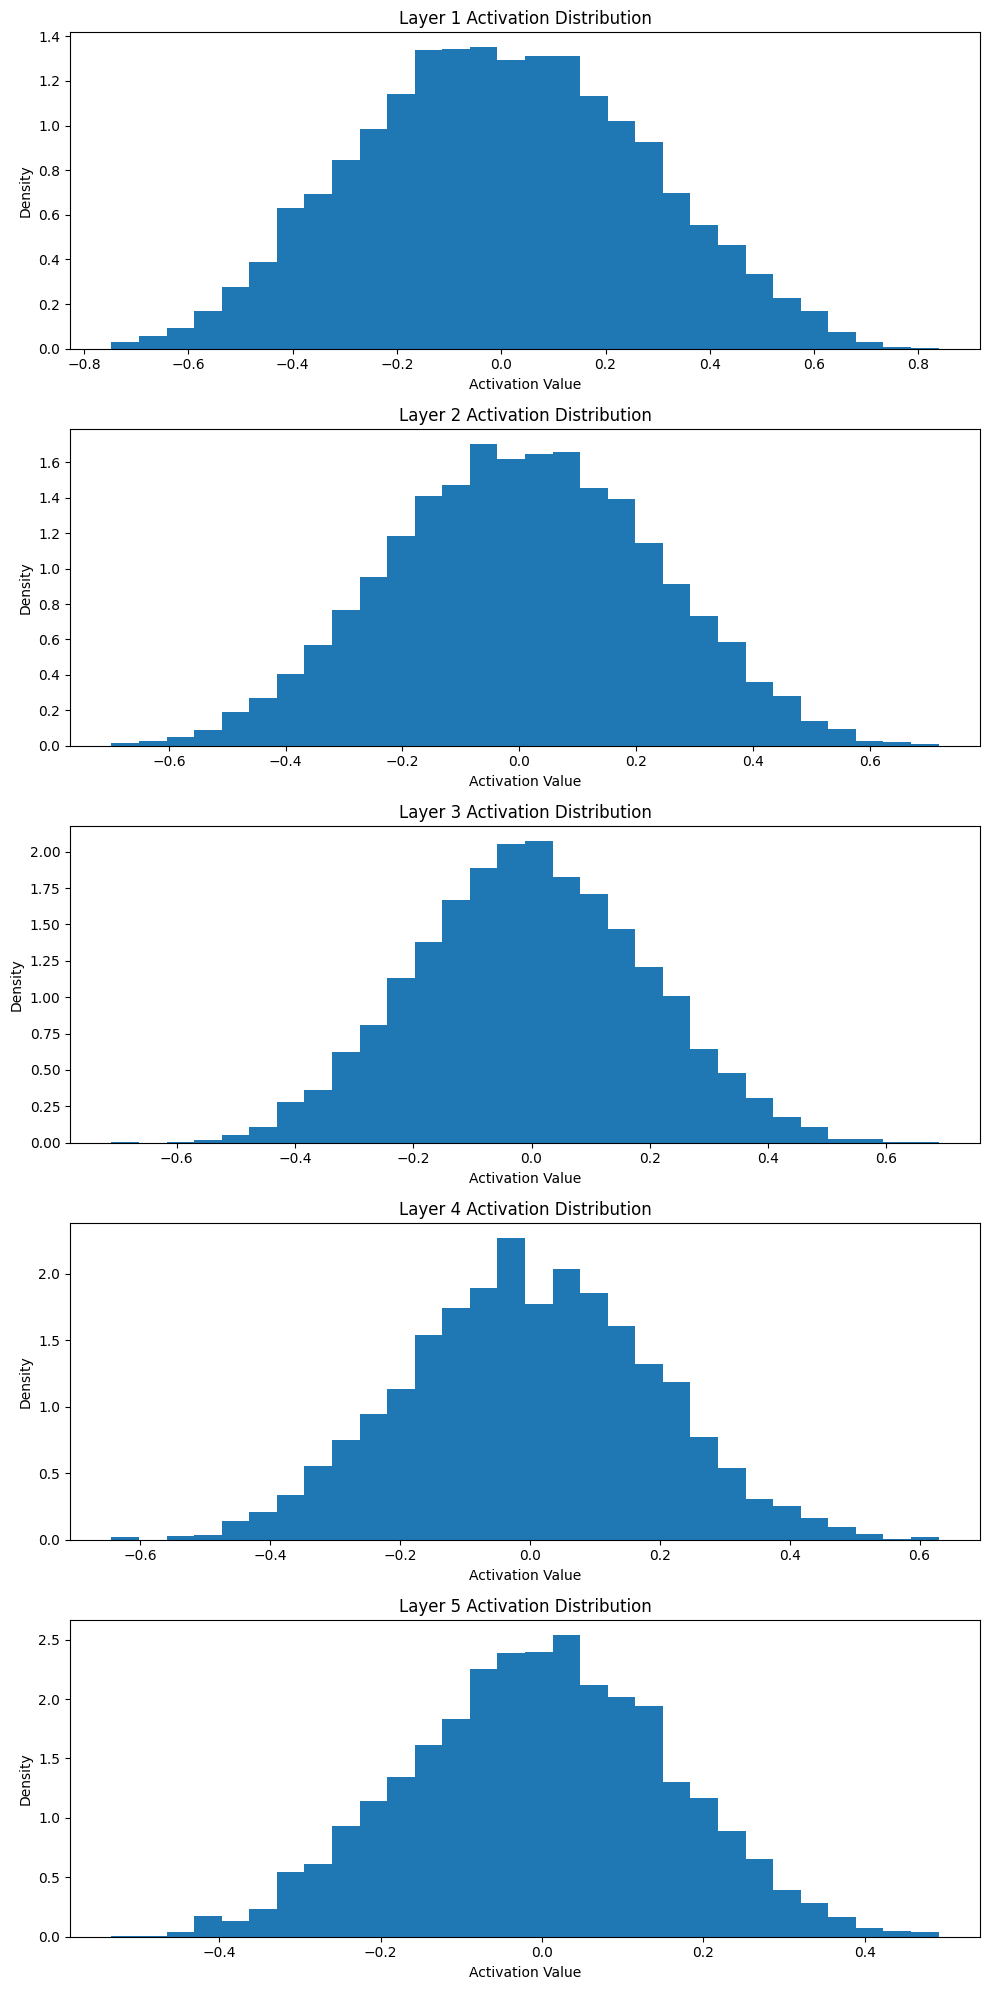

In [27]:
plot_histograms(layer_activations_glorot_normal)

Golorot uniform distrbituion:

In [28]:
mlp_glorot_uniform = GolorotMLP(layer_sizes, init_strategy='glorot_uniform')
layer_activations_glorot_uniform = []
x = input_example
for layer in mlp_glorot_uniform.layers:
    x = tf.matmul(x, layer['weights']) + layer['biases']
    x = tf.math.tanh(x)
    layer_activations_glorot_uniform.append(x)

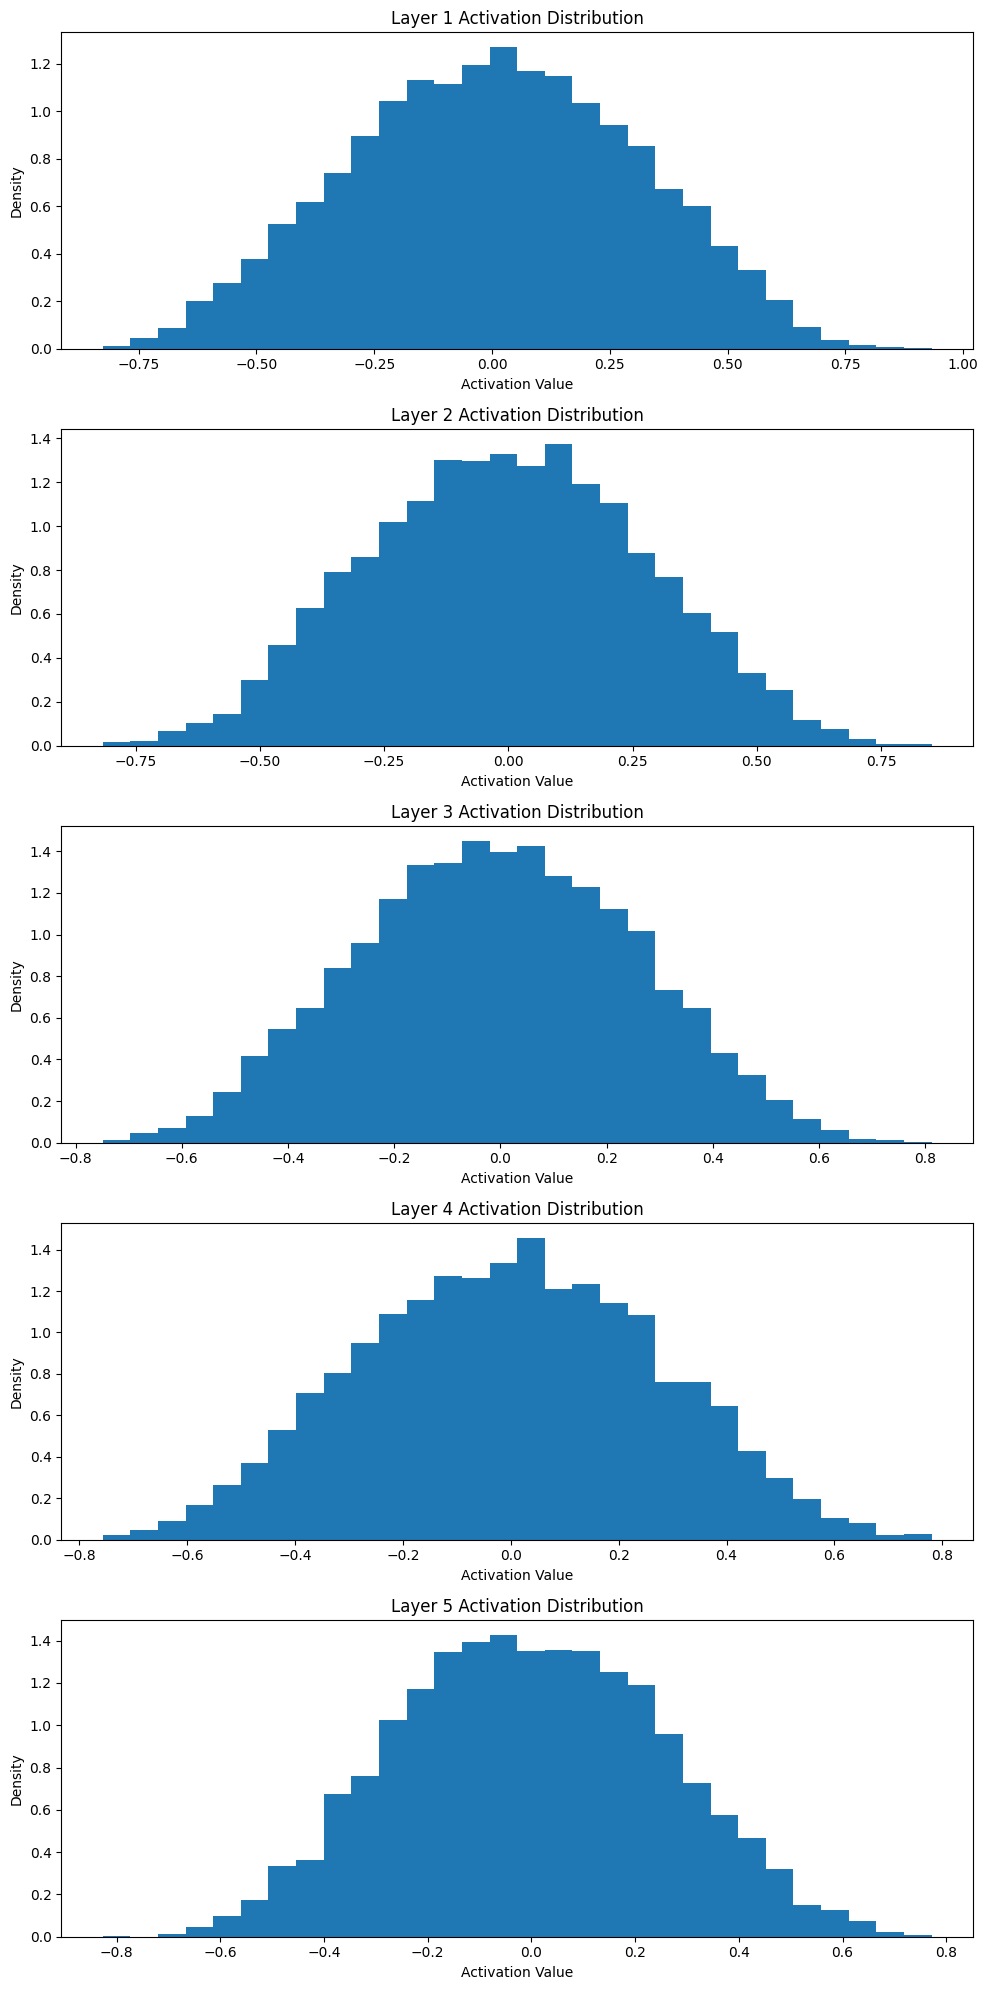

In [29]:
plot_histograms(layer_activations_glorot_uniform)

d) Comment on your interpretation of the results in the previous parts of this question, what implications there might be for the successful training of the MLP model, and any limitations of the empirical study carried out.

**(5 marks)**

**Glorot normal distribution:**


The activation values are now more centered around zero and there are no peaks near -1 or 1 compared to the initial initialization strategy with values saturating at the extremes (-1 and 1). This indicates the neurons are in the more sensitive range of the tanh activation function where gradients are larger and thus can facilitate learning. The histograms resemble a bell shape, implying a normal distribution, meaning the Glorot normal initialization is maintaining a balance in the variance of activations throughout the layers. The spread of activation values across a range without extreme saturation suggests that the network might be able to learn more complex features without the risk of gradients vanishing during backpropagation. Overall, the histograms indicate the Glorot normal initialization strategy has improved the distribution of activations in a way that is likely to better the training process of the network.

**Glorot uniform distribution:**

The Glorot uniform initialization has resulted in activation values that are centered around zero with no peaks near -1 or 1. Similarly, the distributions are quite bell shaped. The range of activations seems to be slightly more constrained compared to the Glorot normal initialization, which is a characteristic of the uniform distribution.

Overall, the histograms for both the Glorot normal and Glorot uniform initializations demonstrate that the activations are well-distributed across the range of the tanh function.

**Implications for Training**:

Proper initialization is beneficial for the training process. It can lead to faster convergence, better generalization, and a lower chance of getting stuck in poor local minima. The observed distributions suggest that Glorot initialization strategies can help in achieving these benefits.

**Limitations of the Empirical Study:**

- Single initialization and input sample: The conclusions are based on single instances of initialization and a single input sample which may not provide robust conclusions. It is more sutiable to repeat the study multiple times with different seeds for the random number generator to ensure that the observations are consistent and not the result of a particular random initialization. The activation statistics were computed based on a single input example, a more robust analysis would consider a batch of inputs to capture the variability in the input space and to observe the batch-wise statistics of the activations. Generally, the study does not account for interactions between initialization and other hyperparameters like learning rate, batch size, or regularization, which can also significantly impact training.
- No training dynamics: The study did not involve actual training of the model with backpropagation and optimization. It is crucial to see how the strategy impacts the training over many epochs and its ability to reach a good solution.
- Model Specificity: The results are specific to the defined architecture and may not generalize to other architectures (such as convolutional neural networks, recurrent neural networks) or activation functions (like ReLU).

### Question 3 (Total 30 marks)

Consider the following MLP model, designed as an image classifier for the MNIST dataset:

$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x}\\
\mathbf{h}^{(k)} &= \sigma\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,2\\
\hat{\mathbf{y}} &= \textrm{softmax}\left( \mathbf{W}^{(2)}\mathbf{h}^{(2)} + \mathbf{b}^{(2)} \right)
\end{align}
$$

where $\mathbf{x}\in\mathbb{R}^{784}$ is the flattened image input, $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$ and $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ ($k=0,1,2$) are the model weights and biases, and $n_k$ is the number of neurons in the $k$-th layer.

a) Construct this MLP model using the Sequential API. The model will have two hidden layers with 64 neurons each, using a sigmoid activation function, and take an input of shape `(28, 28)`. The output should be a 10-way softmax.

Load the MNIST dataset from the Keras API. Normalise the input pixel values to the interval $[0,1]$ and convert the labels to one-hot vectors. Do not shuffle the dataset. Save the training inputs and targets as Tensors `x_train` and `y_train` respectively. The validation/test partition can be discarded.

_Hint: you may find it helpful in later parts of this question to use separate Keras layers for the activation functions inside your model object._

**(5 marks)**

In [30]:
model = Sequential(
    [
        Flatten(input_shape=(28, 28)),  # flatten the input
        Dense(64),  # first hidden layer with 64 neurons
        Activation("sigmoid"),  # activation for the first hidden layer
        Dense(64),  # second hidden layer with 64 neurons
        Activation("sigmoid"),  # activation for the second hidden layer
        Dense(10),  # output layer with 10 neurons (for 10 classes: 0, 1,..., 9)
        Activation("softmax"),  # activation for the output layer
    ]
)

In [31]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255  # normalize the input pixel values
y_train = tf.keras.utils.to_categorical(y_train, 10)  # labels to one-hot vectors

In [32]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

b) Suppose that the loss function used to train the MLP is the categorical cross entropy loss function, and $L_i$ denotes the (scalar-valued) loss with respect to the $i$-th input example. Consider the pre-activations in the final layer, given by $\mathbf{a}^{(3)} =  \mathbf{W}^{(2)}\mathbf{h}^{(2)} + \mathbf{b}^{(2)}$. 

Show that the error $\delta^{(k)} := \frac{\partial L_i}{\partial \mathbf{a}^{(3)}}$ given by the derivative of the loss with respect to the final layer pre-activation values is given by $\hat{\mathbf{y}} - \mathbf{y}$, where $\hat{\mathbf{y}}$ is the output from the model, and $\mathbf{y}$ is the ground truth label, represented as a one-hot vector.

Write your answer below in Markdown. You do not need to write any code for this part.

**(7 marks)**

The categorical cross entropy loss with respect to the $i$-th input example is given by:

   $$
   L_i = - \sum_{c=1}^{C} y_c \log(\hat{y}_c),
   $$

where $C$ is the number of classes, $y_c, \hat{y}_c\in\mathbb{R}^C$, $y_c$ is the true label in one-hot encoded form, and $\hat{y}_c$ is the predicted probability of class $c$.

The output $\hat{\mathbf{y}}$ of the model is obtained by applying the softmax function to the final layer pre-activations $\mathbf{a}^{(3)}$. For class $c$, the probabilities computed using the softmax function are:
   
   $$
   \hat{y}_c = \frac{e^{a_c^{(3)}}}{\sum_{j=1}^{C} e^{a_j^{(3)}}}.
   $$

The error $\delta^{(k)}$ is the derivative of the loss with respect to the final layer pre-activations $\mathbf{a}^{(3)}$. For a particular class $c$ the derivative is:
   $$
   \frac{\partial L_i}{\partial a_c^{(3)}} = \frac{\partial}{\partial a_c^{(3)}} \left( - \sum_{j=1}^{C} y_j \log(\hat{y}_j) \right)
   $$
   
There are two cases:

**Case 1: $j = c$**

$$
\frac{\partial}{\partial a_c^{(3)}} \left( - y_c \log(\hat{y}_c) \right) = - y_c \frac{\partial}{\partial a_c^{(3)}} \log(\hat{y}_c) = - y_c \frac{1}{\hat{y}_c} \hat{y}_c (1 - \hat{y}_c) = - y_c (1 - \hat{y}_c).
$$

**Case 2: $j \neq c$:**

$$
   \frac{\partial}{\partial a_c^{(3)}} \left( - y_j \log(\hat{y}_j) \right) = - y_j \frac{\partial}{\partial a_c^{(3)}} \log(\hat{y}_j) = - y_j \frac{1}{\hat{y}_j} (-\hat{y}_j \hat{y}_c) = y_j \hat{y}_c.
$$

Adding the derivatives from both cases for all classes, we have:
   $$
   \frac{\partial L_i}{\partial a_c^{(3)}} = - y_c (1 - \hat{y}_c) + \sum_{j \neq c} y_j \hat{y}_c
   $$
   
Since $y$ is a one-hot vector, all $y_j$ for $j \neq c$ are 0, and $y_c$ is 1 for the true class and 0 otherwise. Therefore:

   $$
   \frac{\partial L_i}{\partial a_c^{(3)}} = \hat{y}_c - y_c.
   $$

Extending this result to all classes, we obtain the error vector $\delta^{(k)}$ as:
   $$
   \delta^{(k)} = \hat{\mathbf{y}} - \mathbf{y}
   $$


c) Write a function called `grads` that implements the backpropagation equations for this model to return the gradients of the categorical cross entropy loss function with respect to the parameters $\mathbf{W}^{(2)}$ and $\mathbf{b}^{(2)}$. This function should return these gradients as a list `[grads_W2, grads_b2]`, and it should take the following input arguments:

* `model`: your model object, defined using the Sequential API
* `inputs`: a Tensor of shape `(batch_size, 28, 28)`
* `y_true`: a Tensor of shape `(batch_size, 10)` containing the true labels as one-hot vectors

The function `grads` (and any other function it uses) should only use TensorFlow ops. In particular, it should not use automatic differentiation or other libraries (e.g. numpy).

You should make sure that your code is clearly written, and variables sensibly named. You might find it helpful to write separate helper functions to be used in the `grads` function.

 **(15 marks)**

d) Compute the gradients on the first 16 examples in the training set using your `grads` function and model. Print out the gradients that are computed. 

**(3 marks)**

In [33]:
def forward_pass(model, inputs):
    """Perform a forward pass through the model."""
    flatten_layer, dense1, _, dense2, _, dense3, _ = model.layers
    # first layer
    h0 = flatten_layer(inputs)  
    # second layer
    a1 = tf.matmul(h0, dense1.weights[0]) + dense1.bias 
    h1 = tf.keras.activations.sigmoid(a1)
    # third layer
    a2 = tf.matmul(h1, dense2.weights[0]) + dense2.bias 
    h2 = tf.keras.activations.sigmoid(a2)
    # output layer
    a3 = tf.matmul(h2, dense3.weights[0]) + dense3.bias

    return h2, a3


def grads(model, inputs, y_true):
    """Compute gradients of the loss with respect to weights and biases in the last layer."""
    h2, a3 = forward_pass(model, inputs)
    y_pred = tf.keras.activations.softmax(a3)
    error = y_pred - y_true
    grads_W2 = tf.matmul(tf.transpose(h2), error)
    grads_b2 = tf.reduce_sum(error, axis=0)

    return [grads_W2, grads_b2]

In [34]:
batch_size = 16
gradient_values = grads(model, x_train[:batch_size], y_train[:batch_size])

In [35]:
print("Gradients for W2:", gradient_values[0].numpy())

Gradients for W2: [[-3.26479852e-01 -1.49593443e-01 -2.20039412e-01 -1.69229019e+00
  -2.76054204e-01 -3.14520746e-02  4.12293226e-02  1.01003516e+00
   4.82259065e-01  1.16238606e+00]
 [-3.46393943e-01 -5.81707805e-02 -2.64870405e-01 -1.85805333e+00
  -2.71057248e-01 -3.47580314e-02  1.02216326e-01  1.01602352e+00
   4.99146402e-01  1.21591735e+00]
 [-1.66776642e-01 -1.84566006e-02 -1.31086484e-01 -7.88653731e-01
  -1.59314111e-01 -1.76403392e-02  2.88585164e-02  4.71681625e-01
   2.31905624e-01  5.49482286e-01]
 [-1.75717607e-01 -7.26055428e-02 -1.68202758e-01 -1.25866985e+00
  -2.26267114e-01 -1.78753398e-02  7.17382282e-02  6.92405105e-01
   3.44763875e-01  8.10431123e-01]
 [-2.24044338e-01 -6.51101023e-02 -1.61220014e-01 -1.22666931e+00
  -2.03156829e-01 -6.82219192e-02  5.51637523e-02  7.01193333e-01
   3.41635734e-01  8.50430071e-01]
 [-2.22446278e-01 -1.33781508e-01 -2.04003215e-01 -1.51592493e+00
  -2.85520524e-01 -2.31843330e-02  7.54477978e-02  8.75841677e-01
   4.17277545e-

In [36]:
print("Gradients for b2:", gradient_values[1].numpy())


Gradients for b2: [-0.4465304  -0.11848061 -0.37461245 -2.5889184  -0.452508   -0.06596339
  0.10110798  1.4900982   0.72233504  1.7334721 ]
